# Working with Model Level Met

Meteorology providers may choose to compute their data on different vertical levels. For example, the ECMWF IFS product is computed [on 137 model levels](https://confluence.ecmwf.int/display/UDOC/L137+model+level+definitions). The pressure of a given model level is not constant, but varies with time and horizontal position. The pressure at a given point can be computed [following ECMWF guidelines](https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height). This notebook uses the `metview` library to convert from ECMWF model levels to pressure levels.

The [metview package](https://metview.readthedocs.io/en/latest/index.html) can be difficult to install. [Installation with conda](https://metview.readthedocs.io/en/latest/install.html#conda) may be the easiest way to get started. This notebook assumes a working installation of metview.

In [1]:
import os

import cdsapi
import matplotlib.pyplot as plt
import metview as mv
import numpy as np
import pandas as pd
import xarray as xr

from pycontrails import Fleet, Flight, MetDataset
from pycontrails.datalib.ecmwf import PRESSURE_LEVEL_VARIABLES, SURFACE_VARIABLES
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import HistogramMatching
from pycontrails.models.ps_model import PSFlight

## Define CDS model level request

We make three requests to the CDS API.

- `ml_request` is a request for the model levels meteorology data
- `lnsp_request` is a request for the surface pressure data needed for interpolating from model levels to pressure levels
- `sl_request` is a request for the single level top of atmosphere radiation data needed for CoCiP

In [2]:
date = "2024-01-15"
time = list(range(18))
grid = "1/1"

ml_variables = ["t", "q", "u", "v", "w", "ciwc"]
sl_variables = ["tsr", "ttr"]

ml_request = {
    "levtype": "ml",
    "levellist": "70/to/90/by/1",
    "param": ml_variables,
    "date": date,
    "time": time,
    "grid": grid,
}

lnsp_request = {
    "levtype": "ml",
    "levelist": "1",
    "param": "lnsp",
    "date": date,
    "time": time,
    "grid": grid,
}

sl_request = {
    "levtype": "sfc",
    "product_type": "reanalysis",
    "param": sl_variables,
    "date": date,
    "time": time,
    "grid": grid,
    "format": "netcdf",
}

## Make the request

Download the data if it is not already sitting on disk. Depending on the load on the Copernicus server, we may get queued here for a while.

In [3]:
client = cdsapi.Client()

target = "ml.grib"
if not os.path.isfile(target):
    client.retrieve("reanalysis-era5-complete", ml_request, target)

target = "lnsp.grib"
if not os.path.isfile(target):
    client.retrieve("reanalysis-era5-complete", lnsp_request, target)

target = "sl.nc"
if not os.path.isfile(target):
    client.retrieve("reanalysis-era5-single-levels", sl_request, target)

## Target pressure levels

In order to use the `metview` library to convert from model levels to pressure levels, we must specify target pressure levels for the re-interpolation.

Assuming a constant surface pressure of 1013.25 hPa, the table below shows that ECMWF model levels occur roughly every 10 hPa at altitudes for which contrails form. This informs how we set our target pressure levels: We define our target pressure levels ranging from 170 hPa to 390 hPa, spaced every 10 hPa. A finer spacing than this may be redundant (`pycontrails` models perform linear interpolation between pressure levels), and a coarser spacing would result in loss of information.

In [4]:
url = "https://confluence.ecmwf.int/display/UDOC/L137+model+level+definitions"
df = pd.read_html(url, na_values="-", index_col="n")[0].rename_axis("hybrid")
df.loc[70:90]  # model levels 70 - 90 agree with our ml_request

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3]
hybrid,,,,,,,,
70,15508.256836,0.011806,167.0450,163.0927,13077.79,13104.70,216.65,0.262244
71,16026.115234,0.014816,175.2731,171.1591,12771.64,12797.30,216.65,0.275215
72,16527.322266,0.018318,183.8344,179.5537,12467.99,12492.44,216.65,0.288713
73,17008.789063,0.022355,192.7389,188.2867,12166.81,12190.10,216.65,0.302755
74,17467.613281,0.026964,201.9969,197.3679,11868.08,11890.24,216.65,0.317357
75,17901.621094,0.032176,211.6186,206.8078,11571.79,11592.86,216.65,0.332536
76,18308.433594,0.038026,221.6146,216.6166,11277.92,11297.93,216.65,0.348308
77,18685.718750,0.044548,231.9954,226.8050,10986.70,11005.69,216.74,0.364545
78,19031.289063,0.051773,242.7719,237.3837,10696.22,10714.22,218.62,0.378253


## Interpolate from model levels to pressure levels

We use the [mvl_ml2hPa](https://metview.readthedocs.io/en/latest/api/functions/mvl_ml2hPa.html) metview function to interpolate from model levels to pressure levels. This function has some constraints:

- Only a single met parameter can be interpolated in a given function call
- Only a single time can be interpolated in a given function call
- The target pressure levels are assumed to be integers

We loop over all parameters and times to interpolate each parameter at each time. We then concatenate the results into a single `xr.Dataset`.

In [5]:
pressures = np.arange(170, 400, 10)

ds_dict = {}
for param in ml_variables:
    da_list = []
    for t in time:
        lnsp = mv.read(source="lnsp.grib", time=t)
        fsml = mv.read(source="ml.grib", param=param, time=t)
        fspl = mv.mvl_ml2hPa(lnsp, fsml, pressures)
        ds = fspl.to_dataset()
        da = ds.expand_dims("time")[param]
        da_list.append(da)

    da = xr.concat(da_list, dim="time")
    ds_dict[param] = da

ds = xr.Dataset(ds_dict)

In [6]:
# Ready the Dataset for pycontrails
met = MetDataset(
    ds.rename(isobaricInhPa="level"),
    provider="ECMWF",
    dataset="ERA5",
    product="reanalysis",
)
met.standardize_variables(PRESSURE_LEVEL_VARIABLES)
met

MetDataset with data:

<xarray.Dataset> Size: 647MB
Dimensions:                              (time: 18, level: 23, latitude: 181,
                                          longitude: 360)
Coordinates:
  * time                                 (time) datetime64[ns] 144B 2024-01-1...
    step                                 timedelta64[ns] 8B 00:00:00
  * level                                (level) float64 184B 170.0 ... 390.0
  * latitude                             (latitude) float64 1kB -90.0 ... 90.0
    valid_time                           (time) datetime64[ns] 144B 2024-01-1...
  * longitude                            (longitude) float64 3kB -180.0 ... 1...
    air_pressure                         (level) float32 92B 1.7e+04 ... 3.9e+04
    altitude                             (level) float32 92B 1.281e+04 ... 7....
Data variables:
    air_temperature                      (longitude, latitude, level, time) float32 108MB ...
    specific_humidity                    (longitude, latitude, level, time) float32 108MB ...
    eastward_wind                        (longitude, latitude, level, time) float32 108MB ...
    northward_wind                       (longitude, latitude, level, time) float32 108MB ...
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float32 108MB ...
    specific_cloud_ice_water_content     (longitude, latitude, level, time) float32 108MB ...
Attributes:
    provider:  ECMWF
    dataset:   ERA5
    product:   reanalysis

## Missing values

Converting from model levels to pressure levels will result in some missing values. These are plotted below.

Points at which the surface pressure is significantly lower than the 1013.25 hPa reference surface pressure will result in missing values at the lowest-altitude target pressure levels. Additional model levels can be downloaded to decrease the number of missing values. Missing values do not occur at higher-altitude target pressure levels.

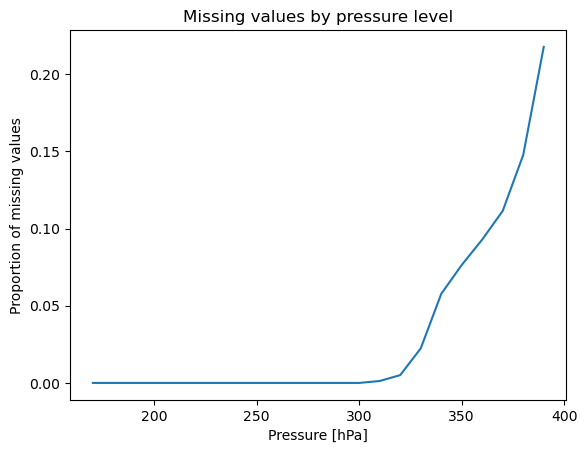

In [7]:
da = met.data["air_temperature"]
da.isnull().groupby("level").mean(...).plot()
plt.ylabel("Proportion of missing values")
plt.title("Missing values by pressure level");

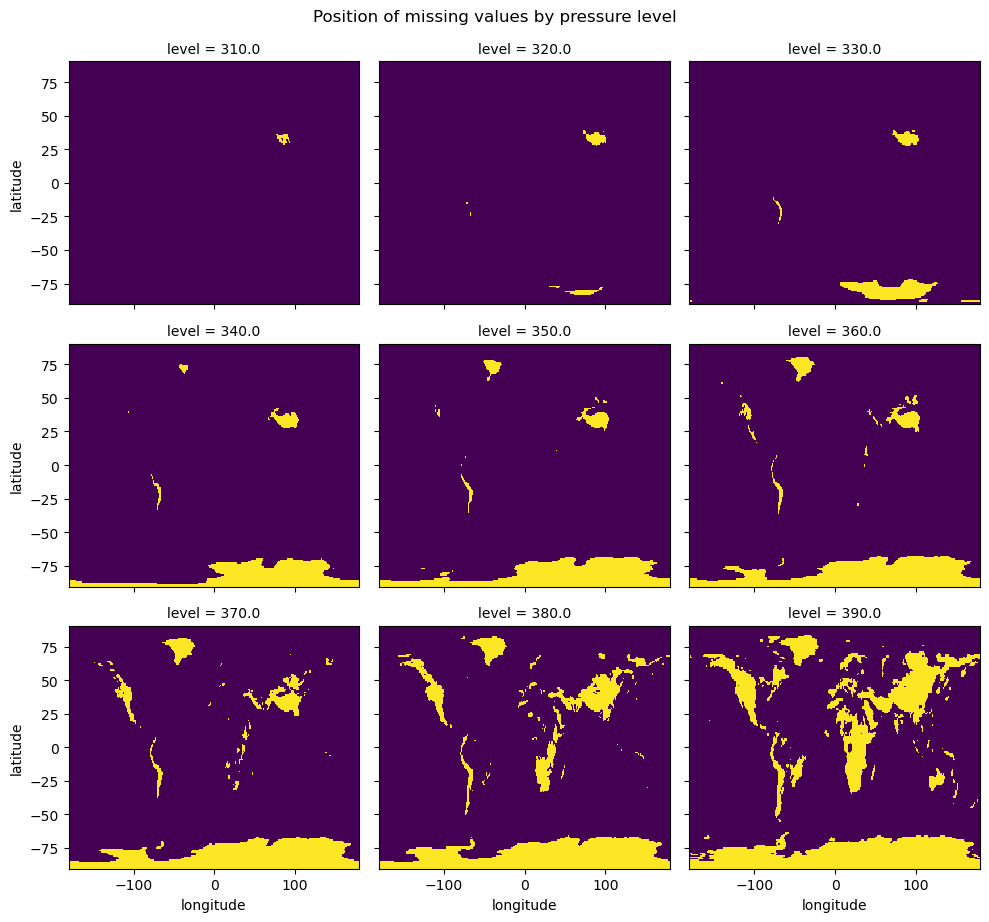

In [8]:
# There are no missing values above 310 hPa
tmp = da.isnull().isel(time=0).sel(level=slice(310, None))
tmp.plot(x="longitude", y="latitude", add_colorbar=False, col="level", col_wrap=3)
plt.gcf().suptitle("Position of missing values by pressure level", y=1.02);

## Single level data

The single level data is much easier to work with. We can read it directly with `xarray` using the `netcdf4` engine.

In [9]:
# Ready the single level data for pycontrails
ds = xr.open_dataset("sl.nc")
ds = ds.expand_dims(level=[-1])

rad = MetDataset(ds, provider="ECMWF", dataset="ERA5", product="reanalysis")
rad.standardize_variables(SURFACE_VARIABLES)
rad

MetDataset with data:

<xarray.Dataset> Size: 9MB
Dimensions:                    (level: 1, latitude: 181, time: 18,
                                longitude: 360)
Coordinates:
  * level                      (level) float64 8B -1.0
  * latitude                   (latitude) float64 1kB -90.0 -89.0 ... 89.0 90.0
  * time                       (time) datetime64[ns] 144B 2024-01-15 ... 2024...
  * longitude                  (longitude) float64 3kB -180.0 -179.0 ... 179.0
Data variables:
    top_net_solar_radiation    (longitude, latitude, level, time) float32 5MB ...
    top_net_thermal_radiation  (longitude, latitude, level, time) float32 5MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-05 06:57:34 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
    provider:     ECMWF
    dataset:      ERA5
    product:      reanalysis

## Download ADS-B

For flight trajectories, we use a sample from [Contrails API](https://api.contrails.org). We artificially shift the times of the flight trajectories to overlap the times of the ERA5 data.

In [10]:
df = pd.read_csv("https://apidocs.contrails.org/_static/fleet_sample.csv", parse_dates=["time"])
df["time"] = df["time"].dt.tz_convert(None)
df = df.rename(columns={"altitude": "altitude_ft"})

# Shift time to the date of interest
df["time"] = df["time"] + (pd.Timestamp(date) - df["time"].min())

# Convert to a pycontrails Fleet instance, keeping only aircraft type covered by the PS model
ps_flight = PSFlight()
flights = []
for flight_id, group in df.groupby("flight_id"):
    aircraft_type = group["aircraft_type"].iloc[0]
    if not ps_flight.check_aircraft_type_availability(aircraft_type, raise_error=False):
        continue

    engine_uid = group["engine_uid"].iloc[0]
    group = group.drop(columns=["aircraft_type", "engine_uid", "flight_id"])
    flight = Flight(group, aircraft_type=aircraft_type, engine_uid=engine_uid, flight_id=flight_id)
    flights.append(flight)

fleet = Fleet.from_seq(flights)

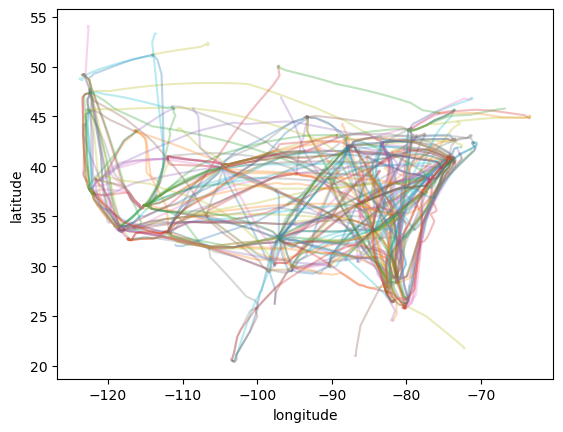

In [11]:
ax = plt.subplot()
for flight in flights:
    flight.plot(ax=ax, alpha=0.3)

## Run CoCiP

We run CoCiP on the model-level ERA5 data.

In [12]:
cocip = Cocip(
    met=met,
    rad=rad,
    dt_integration="5 min",
    max_age="12 hours",
    aircraft_performance=PSFlight(),
    humidity_scaling=HistogramMatching(),
)
cocip_pred = cocip.eval(fleet)
contrail = cocip.contrail

## Visualize output

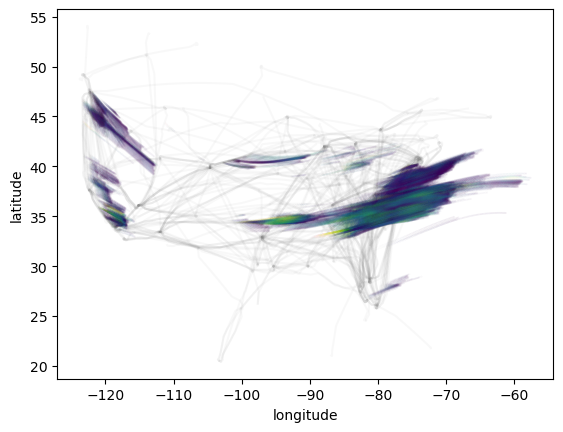

In [13]:
ax = plt.subplot()
for flight in flights:
    flight.plot(ax=ax, color="gray", alpha=0.05)

contrail.plot.scatter(
    x="longitude",
    y="latitude",
    s=contrail["width"] / 100000,
    c=contrail["tau_contrail"],
    vmin=0,
    vmax=0.3,
    alpha=0.05,
    zorder=2,
    ax=ax,
);